## Loss Landscape While Learning 1

```
pip install transformers matplotlib tqdm huggingface_hub notebook
```

In [1]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [2]:
model_id = "meta-llama/Llama-3.2-1B"
# model_id = "openai-community/gpt2"
# model_id = "google/gemma-3-1b-pt"
# model_id = "gpt2"

In [3]:
# Random init
# model_config = GPT2Config() #Full sized model
# model = GPT2LMHeadModel(model_config).to(device) #Ok i should see what happens with full and pretrained model. 
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Not quite working for Llama, will take some noodling
# model_config  = LlamaConfig.from_dict(config_dict)
# model = LlamaForCausalLM(model_config).to(device) 
# tokenizer = AutoTokenizer.from_pretrained(model_id)

#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

### Check loss

In [4]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

In [ ]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

## Baseline

In [5]:
# Define two random directions - takes some memory!
direction1 = [torch.randn_like(p) for i, p in enumerate(model.parameters()) if i<64] #Subset - dont' have enough VRAMS - i think i can do like first 70
direction2 = [torch.randn_like(p) for i, p in enumerate(model.parameters()) if i<64]

# Normalize vectors
for p, d1, d2 in zip(model.parameters(), direction1, direction2):
    norm_p = torch.linalg.norm(p.flatten())
    d1.div_(torch.linalg.norm(d1.flatten())).mul_(norm_p)
    d2.div_(torch.linalg.norm(d2.flatten())).mul_(norm_p)

In [6]:
# Define the range to explore
x = np.linspace(-2.5, 2.5, 24)
y = np.linspace(-2.5, 2.5, 24)
X, Y = np.meshgrid(x, y)

# Prepare to collect the losses
Z = np.zeros_like(X)

model.eval()
# Compute loss for each direction
for i in tqdm(range(x.size)):
    for j in range(y.size):
        with torch.no_grad():
            # Perturb the model parameters
            for p, d1, d2 in zip(model.parameters(), direction1, direction2):
                p.data.add_(x[i]*d1 + y[j]*d2)

            # Compute the loss
            outputs = model(**inputs, labels=inputs['input_ids'])
            Z[i, j] = outputs.loss.item()
            
            # Revert the model parameters
            for p, d1, d2 in zip(model.parameters(), direction1, direction2):
                p.data.sub_(x[i]*d1 + y[j]*d2)

100%|███████████████████████████████████████████| 24/24 [00:49<00:00,  2.08s/it]


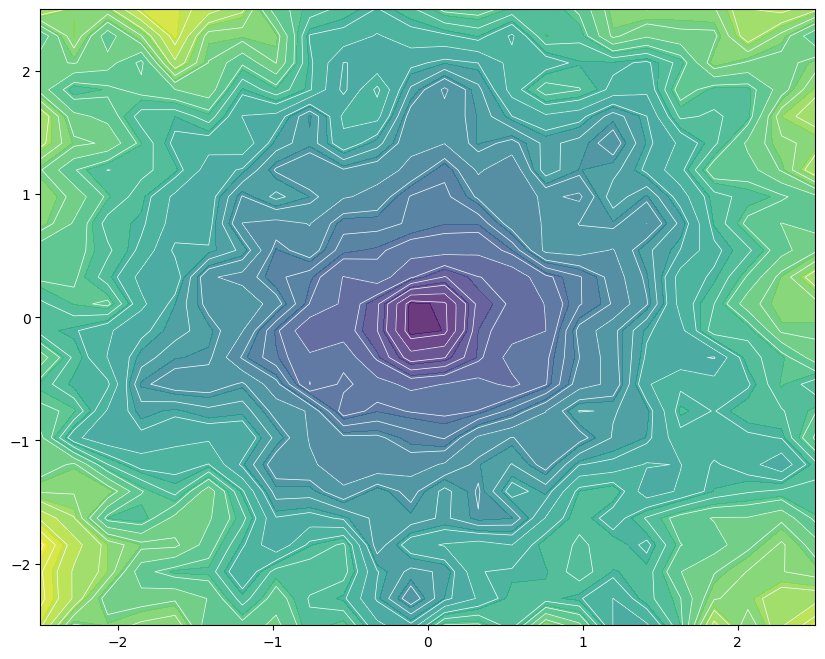

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
contourf = ax.contourf(X, Y, Z, 20, cmap='viridis', alpha=0.8)
contour = ax.contour(X, Y, Z, 30, colors='white', linewidths=0.5)

## Ok now with some learning?
- Hmm is the problem of figuring out where our optimized ends up in this space after a step trivial?
- Or where it is at any point I guess? Hmmm.
- Seems like "projecting to this space" should be a fairly sensible thing -> i want to say it's just the dot product of the current weights with the random directions - will have to think about that a little. 

## Take one Step and recompute landscape

In [5]:
with torch.no_grad():
    outputs = model(**inputs, labels=inputs['input_ids'])
    print(outputs.loss)

tensor(3.3752, device='cuda:0')


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
optimizer.zero_grad()
outputs = model(**inputs, labels=inputs['input_ids'])
outputs.loss.backward()
optimizer.step()

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 64.19 MiB is free. Including non-PyTorch memory, this process has 23.26 GiB memory in use. Of the allocated memory 22.91 GiB is allocated by PyTorch, and 42.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
with torch.no_grad():
    outputs = model(**inputs, labels=inputs['input_ids'])
    print(outputs.loss)

---

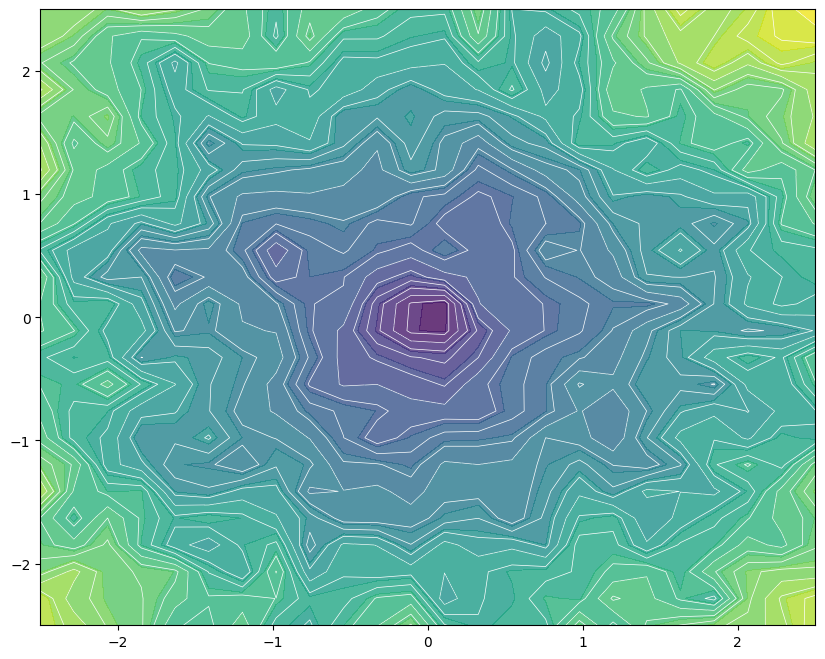

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
contourf = ax.contourf(X, Y, Z, 20, cmap='viridis', alpha=0.8)
contour = ax.contour(X, Y, Z, 30, colors='white', linewidths=0.5)